<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/project%5CKalman_Filters_for_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b

In [79]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

[*********************100%***********************]  1 of 1 completed


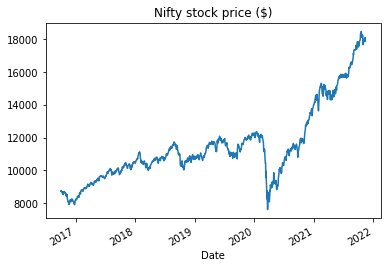

In [80]:
nifty_df = yf.download('^nsei',start='2016-10-01')
nifty_df['Adj Close'].plot(title='Nifty stock price ($)');


In [81]:
#nifty_df = yf.download('sbin.ns',start='2014-01-01',progress=False)


In [82]:
df = nifty_df[['Adj Close']]


mean 15985.518380801626


Text(0.5, 0, 'Days')

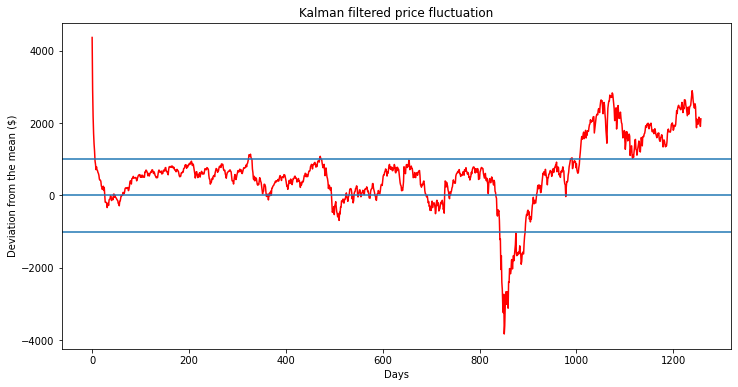

In [83]:
f = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.0001)#0.0001
mean, cov = f.filter(df['Adj Close'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
print(f'mean {mean[-1]}')


plt.figure(figsize=(12,6))
plt.plot(df['Adj Close'].values - mean, 'red', lw=1.5)

plt.axhline(y=0)
plt.axhline(y=1000)
plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation")
plt.ylabel("Deviation from the mean ($)")
plt.xlabel("Days")

In [84]:
nifty =pd.DataFrame({'Date': nifty_df.index,'Close':df['Adj Close'].values - mean})


In [85]:
nifty['30 Day MA'] = nifty['Close'].rolling(window=20).mean()
# set .std(ddof=0) for population std instead of sample
nifty['30 Day STD'] = nifty['Close'].rolling(window=20).std() 
nifty['Upper Band'] = nifty['30 Day MA'] + (nifty['30 Day STD'] *0.5)
nifty['Lower Band'] = nifty['30 Day MA'] - (nifty['30 Day STD'] *0.5)

nifty.ta.macd(append=True)

print()

In [86]:
nifty=nifty.set_index('date')

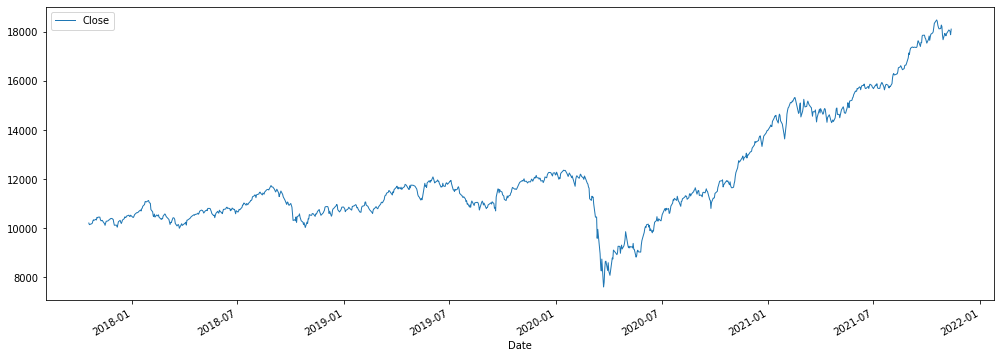

In [87]:
nifty_df[['Close']][-1000:].plot(figsize=(17,6),linewidth=1);

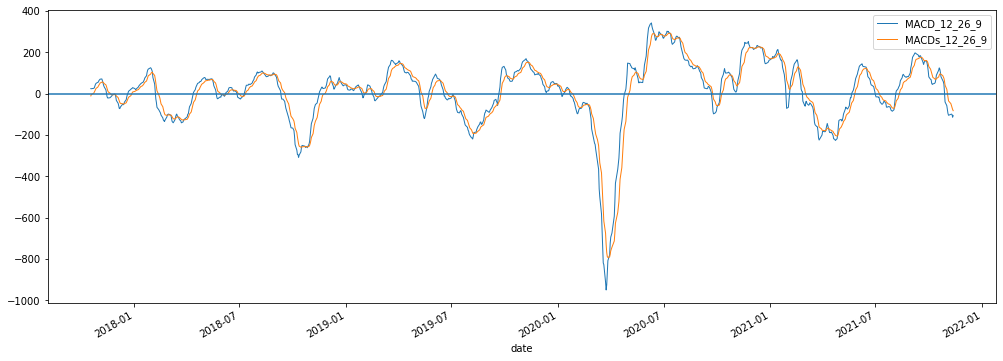

In [88]:
nifty[['MACD_12_26_9','MACDs_12_26_9']][-1000:].plot(figsize=(17,6),linewidth=1);
plt.axhline(y=0);

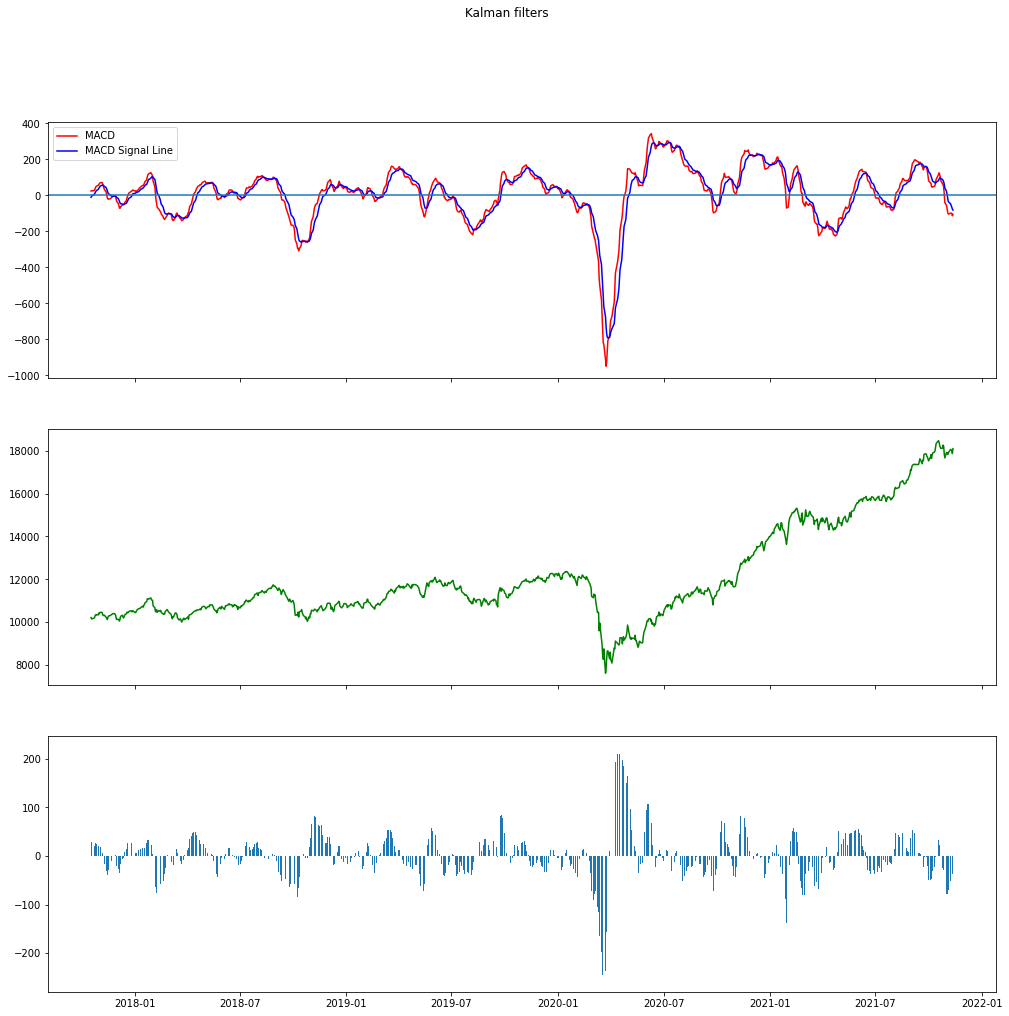

In [89]:
fig, ax = plt.subplots(3,1,figsize=(17,16),linewidth=1,sharex=True)
ax[0].plot(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACD_12_26_9'][-1000:],'r', label='MACD')
ax[0].plot(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACDs_12_26_9'][-1000:],'b', label='MACD Signal Line')
ax[2].bar(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACDh_12_26_9'][-1000:], label='MACD Signal Line')
ax[1].plot(nifty_df.loc[:, :].index[-1000:], nifty_df.loc[:, 'Close'][-1000:],'g', label='NH moving avg 50 days')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Kalman filters')
ax[0].axhline(y=0)
ax[0].legend()
plt.show()


In [ ]:
nifty['signals']=0

for i in range(len(df)):
  if nifty['MACD_12_26_9'].iloc[i]>nifty['MACDs_12_26_9'].iloc[i] and nifty['MACD_12_26_9'].iloc[i-1]<nifty['MACDs_12_26_9'].iloc[i-1]:
    nifty['signals'].iloc[i]=1
  elif nifty['MACD_12_26_9'].iloc[i]<nifty['MACDs_12_26_9'].iloc[i] and nifty['MACD_12_26_9'].iloc[i-1]>nifty['MACDs_12_26_9'].iloc[i-1]:
    nifty['signals'].iloc[i]=-1
 

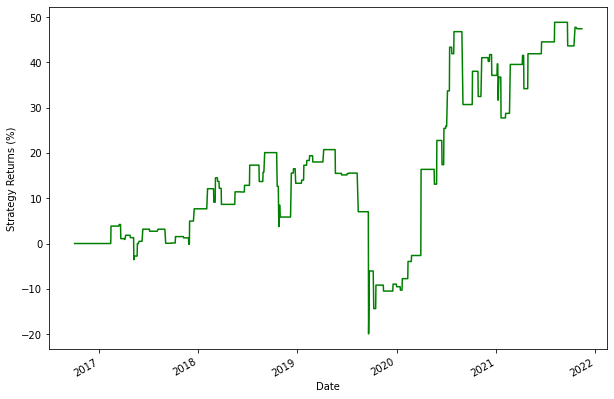

sharpe ratio :  0.05839251765428751


In [120]:
# Calculate daily returns
nifty['Return'] = nifty_df.Close.pct_change()

# Calculate strategy returns
nifty['Strategy_F'] = nifty.Return * nifty.signals.shift(1)

# Calculate geometric returns
geometric_returns = ((nifty.Strategy_F+1).cumprod()-1)*100*5
#np.sum(np.log(data/data.shift())*portfolio, axis=1)
# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
volatility = geometric_returns.std() * np.sqrt(252)
sharpe_ratio = (geometric_returns.mean() - 0.06) / volatility 
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()
print('sharpe ratio : ' ,sharpe_ratio)

In [93]:
nifty['signals'].value_counts()

 0    1163
-1      48
 1      47
Name: signals, dtype: int64

In [94]:
nifty[nifty['signals']==-1].tail(3)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,signals,Return,Strategy_F
date,,,,,,,,,,,
2021-06-16,1877.953774,1831.494758,168.475514,1915.732515,1747.257001,116.471900,-4.656710,121.128609,-1,-0.006409,-0.0
2021-09-20,2291.740391,2279.552143,234.832314,2396.968300,2162.135986,158.821296,-13.562539,172.383835,-1,-0.010705,-0.0
2021-10-22,2429.846017,2511.604636,185.237072,2604.223173,2418.986100,81.041173,-11.996386,93.037559,-1,-0.003477,-0.0


In [95]:
nifty[nifty['signals']==1].index[-1]

Timestamp('2021-10-14 00:00:00')

In [96]:
nifty[nifty['signals']==-1].index[-1]

Timestamp('2021-10-22 00:00:00')

In [97]:
if nifty['signals'].iloc[-1]!=0:
  var=nifty['signals'].iloc[-1]
  print(f'Signal Changed to {var}')
else:
  print(f'no change in signals')
  print(f'last buy signal              last sell signal')
  print(nifty[nifty['signals']==1].index[-1],'::::::::',nifty[nifty['signals']==-1].index[-1])

no change in signals
last buy signal              last sell signal
2021-10-14 00:00:00 :::::::: 2021-10-22 00:00:00


In [98]:
nifty['signals_zeroline']=np.where(nifty['MACD_12_26_9']>0,1,-1)

In [99]:
nifty['sum']=nifty['signals']+nifty['signals_zeroline']

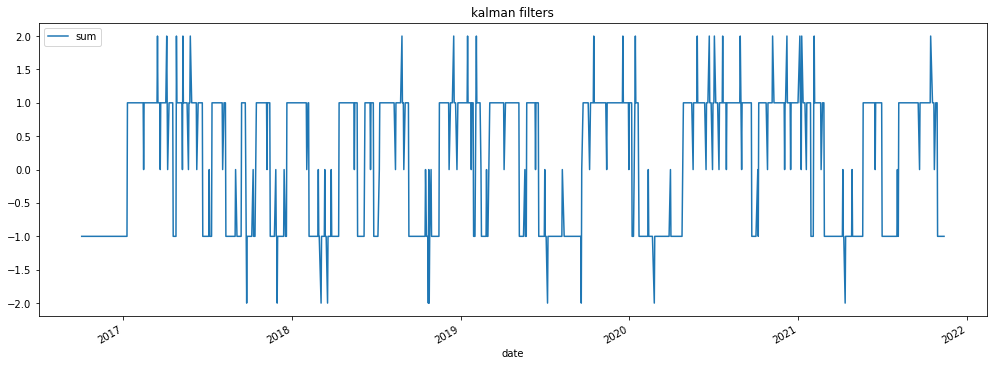

In [100]:
nifty['sum'].plot(kind='line',figsize=(17,6),legend=True,title='kalman filters');

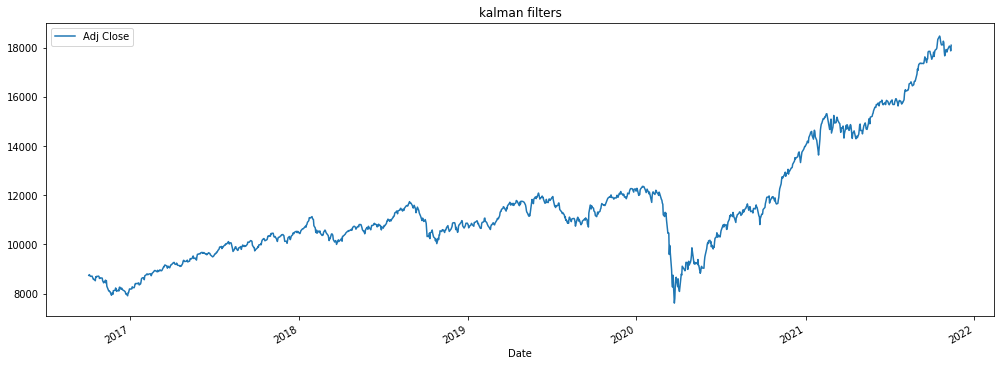

In [101]:
df['Adj Close'].plot(kind='line',figsize=(17,6),legend=True,title='kalman filters');

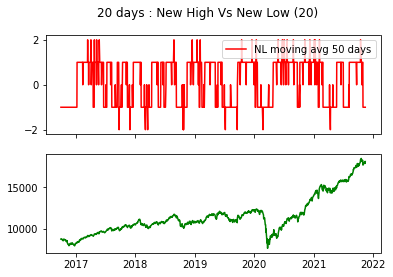

In [102]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'sum'],'r', label='NL moving avg 50 days')
ax[1].plot(df.loc[:, :].index, df.loc[:, 'Adj Close'],'g', label='NH moving avg 50 days')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('20 days : New High Vs New Low (20)')
ax[0].legend()
plt.show()


In [103]:
nifty['sum']=np.where(nifty['sum']>=0,1,-1)

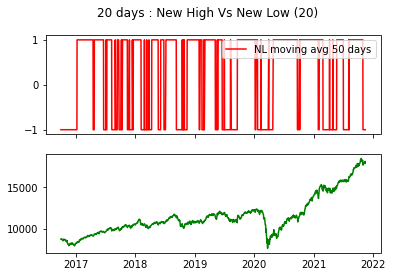

In [104]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'sum'],'r', label='NL moving avg 50 days')
ax[1].plot(df.loc[:, :].index, df.loc[:, 'Adj Close'],'g', label='NH moving avg 50 days')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('20 days : New High Vs New Low (20)')
ax[0].legend()
plt.show()


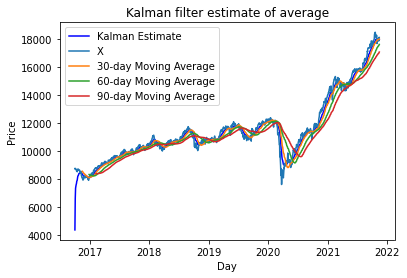

In [105]:
x=df['Adj Close'].copy()
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01) # Kahani yahaa likhi ja rahi hai

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(x.values)
state_means = pd.Series(state_means.flatten(), index=x.index)

# Compute the rolling mean with various lookback windows
mean30 = x.rolling(window = 30).mean()
mean60 = x.rolling(window = 60).mean()
mean90 = x.rolling(window = 90).mean()

# Plot original data and estimated mean
plt.plot(state_means,'b')
plt.plot(x)
plt.plot(mean30)
plt.plot(mean60)
plt.plot(mean90)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price');

In [106]:
nifty['sum'].to_csv('kalman.csv')